In [1]:
# library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

In [2]:
def extract_topsig_genes(main_df, sig = 0.05): # no fdr just P SMR multi < 0.01/20000 and HEIDI > 0.01.
    # create df to hold top genes
    top_gene_df = pd.DataFrame()
    # pval based on largest number of unique protein coding genes amongst NDDs
    pval = sig/16875
    df = main_df.query(f"p_SMR_multi < {pval} & p_HEIDI > 0.01") # initial filter by each dx/omic combo  
    top_gene = df[['Omic', 'Disease', 'Gene','probeID', 'topRSID', 'b_SMR', 'se_SMR','p_SMR', 'p_SMR_multi','p_HEIDI']] # filter out any genes whose fdr pval does not meet defined significance; default = 0.05

    top_gene_df = pd.concat([top_gene_df,top_gene])
    top_gene_df = top_gene_df.drop_duplicates()
        
    return top_gene_df

In [3]:
def extract_top_genes(main_df,dx_list, omic_list):
    # create df to hold top genes
    top_gene_df = pd.DataFrame()
    
    for disease in dx_list:
        for omic in omic_list:
            df = main_df.query(f"Disease == '{disease}' & Omic == '{omic}' & p_SMR_multi < 0.01 & p_HEIDI > 0.01")
            df = fdr(df)
            top_gene = df[df['FDR_pval'] == df['FDR_pval'].min()]
            top_gene = top_gene[['Omic', 'Disease', 'Gene', 'topRSID', 'b_GWAS','p_GWAS', 'b_SMR', 'p_SMR_multi', 'p_HEIDI', 'FDR_pval']]

            top_gene_df = pd.concat([top_gene_df,top_gene])
    return top_gene_df

def top_gene_dx_omic(top_gene_df, dx_list, omic_list):
    top_genes = pd.DataFrame(index = omic_list, columns = dx_list)
    top_rsid = pd.DataFrame(index = omic_list, columns = dx_list)
    
    for index, row in top_gene_df.iterrows():
        omic_ind = row['Omic']
        disease_col = row['Disease']
        if row['Gene'] != 'Novel_or_none':
            top_genes.loc[omic_ind, disease_col] = row['Gene']
        else:
            top_genes.loc[omic_ind, disease_col] = row['topRSID']
            top_rsid.loc[omic_ind, disease_col] = row['topRSID']
    return top_genes, top_rsid

def gene_count(df, col_name):
    counts_df = df.stack().value_counts().rename_axis(col_name).reset_index(name='count')
    return counts_df

def top_gene_dx_count(main_df, min_thresh = 1): # method that returns the number of times a gene shows up in top_gene df for each disease
    top_gene_dx = pd.DataFrame()
    
    for col in main_df.columns:
        df = main_df[col].value_counts().rename_axis(f'{col}_Gene').reset_index(name=f'{col}_gene_count')
        df = df.query(f'{col}_gene_count > {min_thresh}')
        top_gene_dx[f'{col}_Gene'] = df[f'{col}_Gene']
        top_gene_dx[f'{col}_gene_count'] = df[f'{col}_gene_count']
        
    return top_gene_dx

def top_gene_tx_count(main_df, min_thresh = 1): # method that returns the number of times a gene shows up in top_gene df for each disease
    top_gene_dx = pd.DataFrame()
    
    for col in main_df.T.columns:
        df = main_df.T[col].value_counts().rename_axis(f'{col}_Gene').reset_index(name=f'{col}_gene_count')
        df = df.query(f'{col}_gene_count > {min_thresh}')
        top_gene_dx[f'{col}_Gene'] = df[f'{col}_Gene']
        top_gene_dx[f'{col}_gene_count'] = df[f'{col}_gene_count']
        top_gene_dx.dropna(axis = 1,inplace= True)
        
    return top_gene_dx

In [4]:
def top_genes(df, omics_list, disease_list):
    
    # create df that will hold results
    top_genes_df = pd.DataFrame(index = omics_list, columns = disease_list)
    
    for index, row in df.iterrows():
        omic_ind = row['Omic']
        disease_col = row['Disease']
        if row['Gene'] != 'Novel_or_none':
            top_genes_df.loc[omic_ind, disease_col] = row['Gene']
        else:
            top_genes_df.loc[omic_ind, disease_col] = row['topRSID']
    
    return top_genes_df
def top_genes_drugs(df):
    
    # create df that will hold results
    top_genes_df = pd.DataFrame(index = list(df['Omic'].unique()), columns = list(df['Disease'].unique()))
    
    for index, row in df.iterrows():
        omic_ind = row['Omic']
        disease_col = row['Disease']
        if row['Gene'] != 'Novel_or_none':
            top_genes_df.loc[omic_ind, disease_col] = row['Gene']
        else:
            top_genes_df.loc[omic_ind, disease_col] = row['topRSID']
    
    return top_genes_df

In [5]:
# load in SMR results for NDDs
ndd_df = pd.read_csv("/../omicSynth/NDD_SMR_genes.csv")

# read in protein coding genes
coding = pd.read_csv('/../omicSynth/proteincoding_genesym.csv')

# remove novel_or_none
coding = coding.query('Gene_symbol != "novel_or_none"')

# get list
cgenes = list(coding.Gene_symbol)

# remove all non protein coding genes
ndd_df_pc = ndd_df.query('Gene == @cgenes')

In [6]:
# read in drug df
drug_df = pd.read_csv('/../omicSynth/drug_genome_dgidb.csv', sep = ',')
# list of unique gene targets from drug data
thera_genes = list(drug_df['gene_name'].unique())

## Top Genes

In [7]:
eqtls = ['Cerebellum_metaBrain', 'Basalganglia_metaBrain',
       'Spinalcord_metaBrain', 'Hippocampus_metaBrain', 'Cortex_metaBrain',
         'Brain_Frontal_Cortex_BA9',
       'Brain_Cerebellar_Hemisphere', 'psychEncode_prefrontal_cortex',
       'Brain_Cortex', 'Brain_Caudate_basal_ganglia', 'Nerve_Tibial',
       'Muscle_Skeletal', 'Brain_Hippocampus', 'Brain_Substantia_nigra'
        , 'Brain_Hypothalamus', 'Liver',
       'Brain_Anterior_cingulate_cortex_BA24', 'blood_eQTLgen',
       'Brain_Putamen_basal_ganglia', 'Brain_Amygdala', 'brain_eMeta',
       'Whole_Blood', 'Brain_Cerebellum',
       'Brain_Nucleus_accumbens_basal_ganglia']
# filter out multiancestry
ndd_other = ndd_df_pc.query("Omic == @eqtls")
ndd_ma = ndd_df_pc.query("Omic == 'multiancestry'")

In [8]:
thera_genes = list(drug_df['gene_name'].unique())
# split data frame into therapeutic vs non-therapeutic
therapeutic_genes_ma = ndd_ma.query('Gene == @thera_genes')
non_therapeutic_genes_ma = ndd_ma.query('Gene != @thera_genes')

## Extract top genes that are significant
- must have an adjusted p_value < 0.05/16875

In [9]:
ndd_ma_sig = extract_topsig_genes(ndd_ma)
ndd_ma_sig

,Omic,Disease,Gene,probeID,topRSID,b_SMR,se_SMR,p_SMR,p_SMR_multi,p_HEIDI
1392627,multiancestry,AD,PILRB,ENSG00000121716,rs2897358,-0.003103,0.008638,7.194378e-01,1.205748e-09,0.065833
1392628,multiancestry,AD,PILRA,ENSG00000085514,rs7786844,0.003375,0.007977,6.722520e-01,4.833455e-08,0.015732
1392630,multiancestry,AD,MEPCE,ENSG00000146834,rs6970806,-0.001459,0.010732,8.918838e-01,2.137433e-06,0.092928
1396181,multiancestry,AD,PRSS36,ENSG00000178226,rs78924645,-0.088938,0.015121,4.057764e-09,2.103277e-06,0.012325
1396455,multiancestry,AD,ZNF232,ENSG00000167840,rs143649705,-0.038047,0.014457,8.492619e-03,6.349740e-07,0.016861
1396741,multiancestry,AD,FMNL1,ENSG00000184922,rs62063276,-0.134405,0.027169,7.534747e-07,2.210046e-06,0.669715
1396743,multiancestry,AD,ARHGAP27,ENSG00000159314,rs62065394,-0.120032,0.028385,2.351014e-05,2.904745e-06,0.199443
1396748,multiancestry,AD,KANSL1,ENSG00000120071,rs199447,-0.067772,0.011961,1.458958e-08,8.813429e-07,0.876019
1396751,multiancestry,AD,LRRC37A2,ENSG00000238083,rs2532329,-0.048720,0.009023,6.681304e-08,4.574788e-08,0.941813
1396752,multiancestry,AD,ARL17A,ENSG00000185829,rs58879558,-0.081356,0.014219,1.054765e-08,2.124628e-07,0.557038


In [10]:
# export
ndd_ma_sig.to_csv('MA_sig_hits.csv', index = None)

In [11]:
ndd_other_sig = extract_topsig_genes(ndd_other)
ndd_other_sig

,Omic,Disease,Gene,probeID,topRSID,b_SMR,se_SMR,p_SMR,p_SMR_multi,p_HEIDI
271,Cerebellum_metaBrain,AD,GPC2,ENSG00000213420,rs17309333,-0.005518,0.018258,7.624718e-01,8.862247e-07,0.272504
2440,Cerebellum_metaBrain,AD,CR1,ENSG00000203710,rs1830763,0.245292,0.045868,8.901474e-08,1.723238e-08,0.109188
2657,Cerebellum_metaBrain,AD,LRRC37A,ENSG00000176681,rs2696466,-0.065755,0.011450,9.315664e-09,2.127122e-06,0.519064
2658,Cerebellum_metaBrain,AD,ARL17B,ENSG00000228696,rs7225002,-0.062603,0.010536,2.822204e-09,4.203789e-07,0.593753
2701,Cerebellum_metaBrain,AD,ACE,ENSG00000159640,rs4459609,-0.130730,0.022878,1.102263e-08,6.234866e-08,0.550246
...,...,...,...,...,...,...,...,...,...,...
1717384,Brain_Nucleus_accumbens_basal_ganglia,AD,LRRC37A2,ENSG00000238083,rs413917,-0.043294,0.008585,4.586552e-07,6.966281e-07,0.484854
1728224,Brain_Nucleus_accumbens_basal_ganglia,PD,CD38,ENSG00000004468,rs4698413,-0.317415,0.060710,1.710260e-07,4.311773e-07,0.446134
1728684,Brain_Nucleus_accumbens_basal_ganglia,PD,GPNMB,ENSG00000136235,rs199357,0.121781,0.024914,1.018557e-06,8.078376e-07,0.100483
1730055,Brain_Nucleus_accumbens_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs753236,-0.569009,0.089788,2.339136e-10,3.652036e-10,0.945530


In [12]:
ma_set = set(list(ndd_ma_sig.Gene.unique()))
other_set =  set(list(ndd_other_sig.Gene.unique()))

In [13]:
len(ma_set)

11

In [14]:
len(other_set)

99

In [15]:
ma_set

{'ARHGAP27',
 'ARL17A',
 'FMNL1',
 'GPNMB',
 'KANSL1',
 'LRRC37A2',
 'MEPCE',
 'PILRA',
 'PILRB',
 'PRSS36',
 'ZNF232'}

In [16]:
list(other_set.intersection(ma_set))

['ARHGAP27',
 'ARL17A',
 'GPNMB',
 'PRSS36',
 'PILRA',
 'KANSL1',
 'LRRC37A2',
 'PILRB',
 'ZNF232']

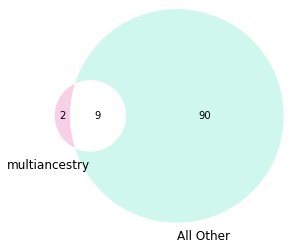

In [17]:
venn2(subsets = [ma_set, other_set], set_labels = ('multiancestry', 'All Other'), set_colors=['#f5c1df', '#c1f5e7'], alpha = 0.75, normalize_to = 100)

In [18]:
ndd_ma_thera = ndd_ma_sig.query('Gene == @thera_genes')
ndd_ma_nonthera = ndd_ma_sig.query('Gene != @thera_genes')

ndd_other_thera = ndd_other_sig.query('Gene == @thera_genes')
ndd_other_nonthera = ndd_other_sig.query('Gene != @thera_genes')

In [19]:
# get unique gene sets for each subset
ma_set_thera = set(list(ndd_ma_thera.Gene.unique()))
ma_set_nonthera = set(list(ndd_ma_nonthera.Gene.unique()))

other_set_thera = set(list(ndd_other_thera.Gene.unique()))
other_set_nonthera = set(list(ndd_other_nonthera.Gene.unique()))

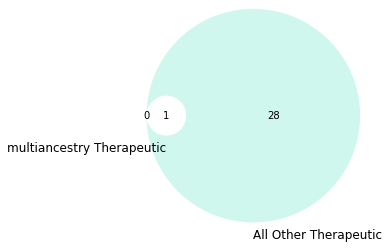

In [20]:
venn2(subsets = [ma_set_thera, other_set_thera], set_labels = ('multiancestry Therapeutic', 'All Other Therapeutic'), set_colors=['#f5c1df', '#c1f5e7'], alpha = 0.75, normalize_to = 100)
plt.show()

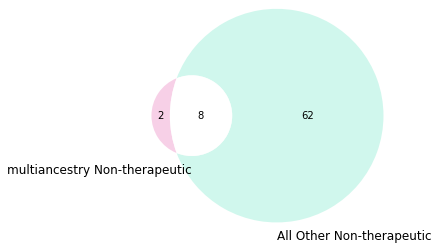

In [21]:
venn2(subsets = [ma_set_nonthera, other_set_nonthera], set_labels = ('multiancestry Non-therapeutic', 'All Other Non-therapeutic'), set_colors=['#f5c1df', '#c1f5e7'], alpha = 0.75, normalize_to = 100)
plt.show()

In [22]:
other_ndd = set(list(ndd_other.Gene.unique()))
ma_set = set(list(ndd_ma.Gene.unique()))

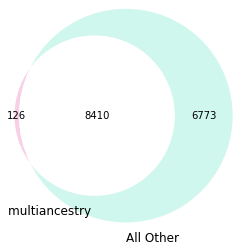

In [23]:
venn2(subsets = [ma_set, other_ndd], set_labels = ('multiancestry ', 'All Other'), set_colors=['#f5c1df', '#c1f5e7'], alpha = 0.75, normalize_to = 100)

In [46]:
len(other_ndd) 

15183

In [47]:
len(ma_set)

8536

In [49]:
ndd_other_sig

,Omic,Disease,Gene,probeID,topRSID,b_SMR,se_SMR,p_SMR,p_SMR_multi,p_HEIDI
271,Cerebellum_metaBrain,AD,GPC2,ENSG00000213420,rs17309333,-0.005518,0.018258,7.624718e-01,8.862247e-07,0.272504
2440,Cerebellum_metaBrain,AD,CR1,ENSG00000203710,rs1830763,0.245292,0.045868,8.901474e-08,1.723238e-08,0.109188
2657,Cerebellum_metaBrain,AD,LRRC37A,ENSG00000176681,rs2696466,-0.065755,0.011450,9.315664e-09,2.127122e-06,0.519064
2658,Cerebellum_metaBrain,AD,ARL17B,ENSG00000228696,rs7225002,-0.062603,0.010536,2.822204e-09,4.203789e-07,0.593753
2701,Cerebellum_metaBrain,AD,ACE,ENSG00000159640,rs4459609,-0.130730,0.022878,1.102263e-08,6.234866e-08,0.550246
...,...,...,...,...,...,...,...,...,...,...
1717384,Brain_Nucleus_accumbens_basal_ganglia,AD,LRRC37A2,ENSG00000238083,rs413917,-0.043294,0.008585,4.586552e-07,6.966281e-07,0.484854
1728224,Brain_Nucleus_accumbens_basal_ganglia,PD,CD38,ENSG00000004468,rs4698413,-0.317415,0.060710,1.710260e-07,4.311773e-07,0.446134
1728684,Brain_Nucleus_accumbens_basal_ganglia,PD,GPNMB,ENSG00000136235,rs199357,0.121781,0.024914,1.018557e-06,8.078376e-07,0.100483
1730055,Brain_Nucleus_accumbens_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs753236,-0.569009,0.089788,2.339136e-10,3.652036e-10,0.945530


In [28]:
ndd_ma_sig.sort_values('Gene', inplace = True)

In [34]:
ndd_ma_sig.Gene.unique()

array(['ARHGAP27', 'ARL17A', 'FMNL1', 'GPNMB', 'KANSL1', 'LRRC37A2',
       'MEPCE', 'PILRA', 'PILRB', 'PRSS36', 'ZNF232'], dtype=object)

In [29]:
ndd_ma_sig.to_csv('MA_replicated genes.csv', index = False)

In [37]:
ma_genes_sig = list(ndd_ma_sig.Gene.unique())
ndd_other_ma_rep = ndd_other_sig.query("Gene == @ma_genes_sig")

In [38]:
ndd_other_ma_rep.sort_values('Gene')

,Omic,Disease,Gene,probeID,topRSID,b_SMR,se_SMR,p_SMR,p_SMR_multi,p_HEIDI
1281346,Brain_Caudate_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs62055544,-0.990049,0.189962,1.869852e-07,2.022244e-07,0.200706
1730055,Brain_Nucleus_accumbens_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs753236,-0.569009,0.089788,2.339136e-10,3.652036e-10,0.945530
1579411,blood_eQTLgen,PSP,ARHGAP27,ENSG00000159314,rs11012,-8.041700,0.752918,1.253104e-26,1.305912e-12,0.016032
1730072,Brain_Nucleus_accumbens_basal_ganglia,PD,ARL17A,ENSG00000185829,rs58879558,-0.234593,0.033678,3.267703e-12,7.112257e-11,0.169512
1281362,Brain_Caudate_basal_ganglia,PD,ARL17A,ENSG00000185829,rs2942166,-0.297649,0.046695,1.837852e-10,3.271795e-09,0.282266
...,...,...,...,...,...,...,...,...,...,...
1246860,Brain_Cortex,AD,PRSS36,ENSG00000178226,rs1549299,-0.064303,0.012623,3.504210e-07,1.826090e-06,0.446560
1111662,Cortex_metaBrain,AD,PRSS36,ENSG00000178226,rs55667375,-0.095769,0.016526,6.835414e-09,2.416914e-06,0.424972
1106585,Cortex_metaBrain,AD,ZNF232,ENSG00000167840,rs143649705,-0.051467,0.019659,8.845842e-03,1.932692e-06,0.153291
1610627,brain_eMeta,AD,ZNF232,ENSG00000167840,rs55777955,-0.111810,0.023098,1.293728e-06,1.124905e-06,0.191948


In [39]:
all_rep_hits = pd.concat([ndd_other_ma_rep,ndd_ma_sig]).sort_values('Gene')
all_rep_hits

,Omic,Disease,Gene,probeID,topRSID,b_SMR,se_SMR,p_SMR,p_SMR_multi,p_HEIDI
1396743,multiancestry,AD,ARHGAP27,ENSG00000159314,rs62065394,-0.120032,0.028385,2.351014e-05,2.904745e-06,0.199443
1579411,blood_eQTLgen,PSP,ARHGAP27,ENSG00000159314,rs11012,-8.041700,0.752918,1.253104e-26,1.305912e-12,0.016032
1730055,Brain_Nucleus_accumbens_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs753236,-0.569009,0.089788,2.339136e-10,3.652036e-10,0.945530
1281346,Brain_Caudate_basal_ganglia,PD,ARHGAP27,ENSG00000159314,rs62055544,-0.990049,0.189962,1.869852e-07,2.022244e-07,0.200706
1462902,Brain_Hypothalamus,PD,ARL17A,ENSG00000185829,rs17573607,-0.227603,0.033841,1.748823e-11,3.975815e-10,0.764424
...,...,...,...,...,...,...,...,...,...,...
1396181,multiancestry,AD,PRSS36,ENSG00000178226,rs78924645,-0.088938,0.015121,4.057764e-09,2.103277e-06,0.012325
1610627,brain_eMeta,AD,ZNF232,ENSG00000167840,rs55777955,-0.111810,0.023098,1.293728e-06,1.124905e-06,0.191948
1342980,Muscle_Skeletal,AD,ZNF232,ENSG00000167840,rs143649705,-0.034084,0.013012,8.810166e-03,1.438383e-06,0.221429
1106585,Cortex_metaBrain,AD,ZNF232,ENSG00000167840,rs143649705,-0.051467,0.019659,8.845842e-03,1.932692e-06,0.153291


In [32]:
ndd_other_ma_rep.to_csv('Non_ma_genes_rep.csv', index = None)